# Business Understanding

# Data Understanding

In [1]:
#import necessary libraries
import keras
from keras.datasets import cifar10
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras.applications import ResNet50, ResNet152V2, DenseNet121
from keras.layers import Dense, Dropout, Activation, Input, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from PIL import Image 
import os, shutil
from tensorflow.keras.preprocessing import image

In [2]:
#defining folder variables
train_folder = 'data/chest_xray/test'
test_folder = 'data/chest_xray/train'
val_folder =  'data/chest_xray/val'

In [3]:
#defining folder variables
train_normal = 'data/chest_xray/train/NORMAL/'
train_pneumonia = 'data/chest_xray/train/PNEUMONIA/'

test_normal = 'data/chest_xray/test/NORMAL/'
test_pneumonia = 'data/chest_xray/test/PNEUMONIA/'

val_normal = 'data/chest_xray/val/NORMAL/'
val_pneumonia = 'data/chest_xray/val/PNEUMONIA/'

In [4]:
#counting how many images there are in each folder
imgs_pneumonia = [file for file in os.listdir(train_pneumonia) if file.endswith('.jpeg')]

print('There are', len(imgs_pneumonia), 'pneumonia images')

There are 3875 pneumonia images


In [5]:
imgs_normal = [file for file in os.listdir(train_normal) if file.endswith('.jpeg')]

print('There are', len(imgs_normal), 'normal images')

There are 1341 normal images


In [6]:
print('There are', len(os.listdir(train_pneumonia)), 'pneumonia images in the training set')

There are 3876 pneumonia images in the training set


In [7]:
print('There are', len(os.listdir(val_pneumonia)), 'pneumonia images in the validation set')

There are 9 pneumonia images in the validation set


In [8]:
print('There are', len(os.listdir(test_pneumonia)), 'pneumonia images in the test set')

There are 390 pneumonia images in the test set


In [9]:
print('There are', len(os.listdir(train_normal)), 'normal images in the training set')

There are 1342 normal images in the training set


In [10]:
print('There are', len(os.listdir(test_normal)), 'normal images in the test set')

There are 234 normal images in the test set


In [11]:
print('There are', len(os.listdir(val_normal)), 'normal images in the validation set')

There are 9 normal images in the validation set


In [12]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [13]:
#defining variables to randomly select 5 images for viewing
normal_images = [img for img in os.listdir(f'{train_normal}')]
pneumonia_images = [img for img in os.listdir(f'{train_pneumonia}')]

In [14]:
#randomly selecting 5 images from the folders
normal_select = np.random.choice(normal_images, 5, replace=False)
pneumonia_select = np.random.choice(pneumonia_images, 5, replace=False)

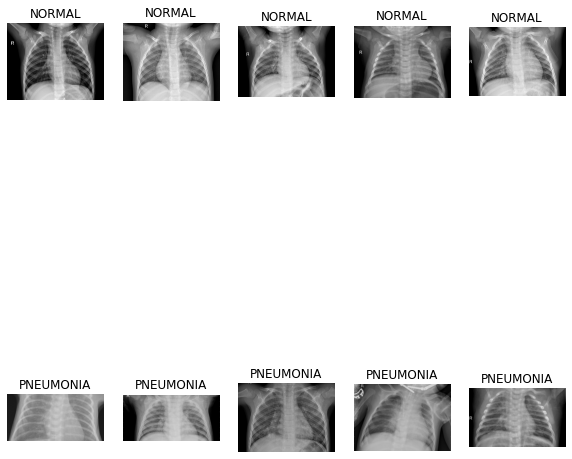

In [15]:
#plotting the random images
fig = plt.figure(figsize=(10,12))
for i in range(10):
    if i<5:
        fpath = f'{train_normal}/{normal_select[i]}'
        label = 'NORMAL'
    else:
        fpath = f'{train_pneumonia}/{pneumonia_select[i-5]}'
        label = 'PNEUMONIA'
    ax = fig.add_subplot(2,5,i+1)
    
    im = image.load_img(fpath)
    plt.imshow(im)
    plt.title(label)
    plt.axis('off')
plt.show()

# Data Preparation

In [16]:
#normalizing and resizing images
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), batch_size = 624) 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(64, 64), batch_size = 16)

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(64, 64), batch_size=5216)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [17]:
#defining the images and labels to prep for model
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [18]:
#counting the number of images and getting the shape of the images
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 624
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (624, 64, 64, 3)
train_labels shape: (624, 2)
test_images shape: (624, 64, 64, 3)
test_labels shape: (624, 2)
val_images shape: (16, 64, 64, 3)
val_labels shape: (16, 2)


In [19]:
#reshaping the images
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(624, 12288)
(624, 12288)
(16, 12288)


In [20]:
#reshaping the images
train_y = np.reshape(train_labels[:,0], (624,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

## Baseline Models

In [21]:
#building a baseline model
from keras import models
from keras import layers

np.random.seed(123)
model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(12288,))) # 2 hidden layers
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [22]:
#compiling the model
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

baseline_history = model.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/50
20/20 [==============================] - 0s 15ms/step - loss: 0.7297 - accuracy: 0.6122 - val_loss: 0.7170 - val_accuracy: 0.5000
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6426 - val_loss: 0.7327 - val_accuracy: 0.5000
Epoch 3/50
20/20 [==============================] - 0s 3ms/step - loss: 0.6068 - accuracy: 0.7051 - val_loss: 0.8431 - val_accuracy: 0.5000
Epoch 4/50
20/20 [==============================] - 0s 3ms/step - loss: 0.5714 - accuracy: 0.7179 - val_loss: 0.7508 - val_accuracy: 0.5000
Epoch 5/50
20/20 [==============================] - 0s 3ms/step - loss: 0.5164 - accuracy: 0.7596 - val_loss: 0.6235 - val_accuracy: 0.7500
Epoch 6/50
20/20 [==============================] - 0s 3ms/step - loss: 0.5025 - accuracy: 0.7580 - val_loss: 0.6885 - val_accuracy: 0.5625
Epoch 7/50
20/20 [==============================] - 0s 3ms/step - loss: 0.4996 - accuracy: 0.7564 - val_loss: 0.6594 - val_accuracy: 0.6875
Epoch 8/50
20/20 [=

In [23]:
results_train = model.evaluate(train_img, train_y)

20/20 [==============================] - 0s 1ms/step - loss: 0.3147 - accuracy: 0.8574


In [24]:
results_test = model.evaluate(test_img, test_y)

20/20 [==============================] - 0s 1ms/step - loss: 0.5147 - accuracy: 0.7885


In [25]:
results_train

[0.31470170617103577, 0.8573718070983887]

In [26]:
results_test

[0.514661431312561, 0.7884615659713745]

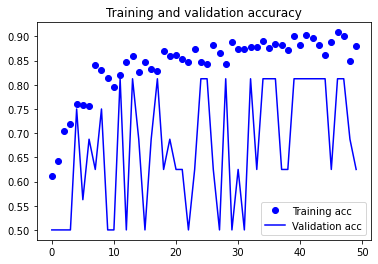

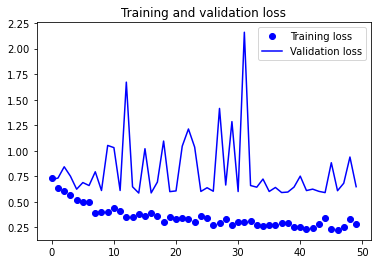

In [27]:
acc_base1 = baseline_history.history['accuracy']
val_acc_base1 = baseline_history.history['val_accuracy']
loss_base1 = baseline_history.history['loss']
val_loss_base1 = baseline_history.history['val_loss']
epochs_base1 = range(len(acc_base1))
plt.plot(epochs_base1, acc_base1, 'bo', label='Training acc')
plt.plot(epochs_base1, val_acc_base1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs_base1, loss_base1, 'bo', label='Training loss')
plt.plot(epochs_base1, val_loss_base1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [28]:
#building a CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [29]:
baseline2_history = model.fit(train_images,
                    train_y,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Epoch 1/30
20/20 [==============================] - 2s 88ms/step - loss: 0.6781 - acc: 0.6250 - val_loss: 0.7063 - val_acc: 0.5000
Epoch 2/30
20/20 [==============================] - 2s 83ms/step - loss: 0.6682 - acc: 0.6250 - val_loss: 0.7143 - val_acc: 0.5000
Epoch 3/30
20/20 [==============================] - 2s 84ms/step - loss: 0.6653 - acc: 0.6250 - val_loss: 0.7184 - val_acc: 0.5000
Epoch 4/30
20/20 [==============================] - 2s 83ms/step - loss: 0.6625 - acc: 0.6250 - val_loss: 0.7180 - val_acc: 0.5000
Epoch 5/30
20/20 [==============================] - 2s 86ms/step - loss: 0.6591 - acc: 0.6250 - val_loss: 0.7094 - val_acc: 0.5000
Epoch 6/30
20/20 [==============================] - 2s 83ms/step - loss: 0.6568 - acc: 0.6250 - val_loss: 0.7050 - val_acc: 0.5000
Epoch 7/30
20/20 [==============================] - 2s 89ms/step - loss: 0.6537 - acc: 0.6250 - val_loss: 0.7278 - val_acc: 0.5000
Epoch 8/30
20/20 [==============================] - 2s 88ms/step - loss: 0.6501 - a

In [30]:
results_train = model.evaluate(train_images, train_y)

20/20 [==============================] - 0s 22ms/step - loss: 0.3322 - acc: 0.8510


In [31]:
results_test = model.evaluate(test_images, test_y)

20/20 [==============================] - 0s 21ms/step - loss: 0.3136 - acc: 0.8590


In [32]:
results_train

[0.33220529556274414, 0.8509615659713745]

In [33]:
results_test

[0.31363701820373535, 0.8589743375778198]

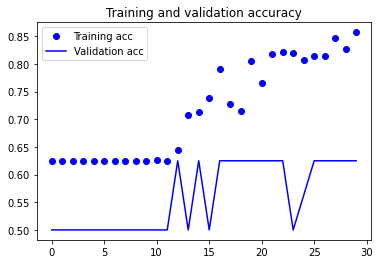

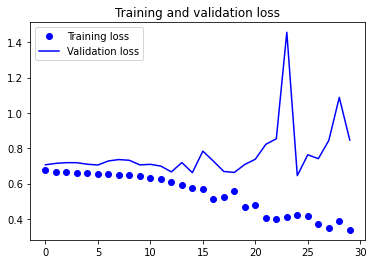

In [34]:
acc = baseline2_history.history['acc']
val_acc = baseline2_history.history['val_acc']
loss = baseline2_history.history['loss']
val_loss = baseline2_history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Data Augmentation

In [47]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)

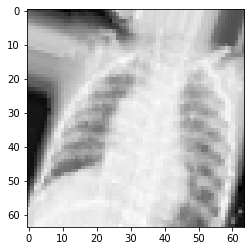

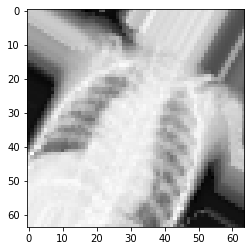

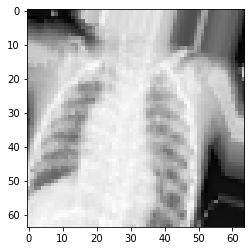

In [53]:
names = [os.path.join(train_pneumonia, name) for name in os.listdir(train_pneumonia)]
img_path = names[91]
img = load_img(img_path, target_size=(64, 64))

reshape_img = img_to_array(img) 
reshape_img = reshape_img.reshape((1,) + reshape_img.shape) 
i=0
for batch in train_datagen.flow(reshape_img, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
plt.show()

In [55]:
#reshaping the generated images

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), 
        batch_size = 624,
        class_mode='binary') 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(64, 64),
        batch_size = 16,
        class_mode='binary')

train_generator = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(64, 64), 
        batch_size = 16, 
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Final Model

In [100]:
#building the final CNN
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 32)        16416     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 2304)            

In [101]:
#fitting the model
history_aug = model.fit(train_generator,
                      epochs=30,
                      validation_data=val_generator)

Epoch 1/30
39/39 [==============================] - 7s 188ms/step - loss: 0.6727 - acc: 0.6250 - val_loss: 0.7176 - val_acc: 0.5000
Epoch 2/30
39/39 [==============================] - 7s 184ms/step - loss: 0.6665 - acc: 0.6250 - val_loss: 0.7446 - val_acc: 0.5000
Epoch 3/30
39/39 [==============================] - 7s 185ms/step - loss: 0.6667 - acc: 0.6250 - val_loss: 0.7239 - val_acc: 0.5000
Epoch 4/30
39/39 [==============================] - 7s 189ms/step - loss: 0.6678 - acc: 0.6250 - val_loss: 0.7047 - val_acc: 0.5000
Epoch 5/30
39/39 [==============================] - 9s 221ms/step - loss: 0.6638 - acc: 0.6250 - val_loss: 0.7281 - val_acc: 0.5000
Epoch 6/30
39/39 [==============================] - 8s 215ms/step - loss: 0.6635 - acc: 0.6250 - val_loss: 0.7081 - val_acc: 0.5000
Epoch 7/30
39/39 [==============================] - 8s 214ms/step - loss: 0.6627 - acc: 0.6250 - val_loss: 0.7024 - val_acc: 0.5000
Epoch 8/30
39/39 [==============================] - 8s 212ms/step - loss: 0.

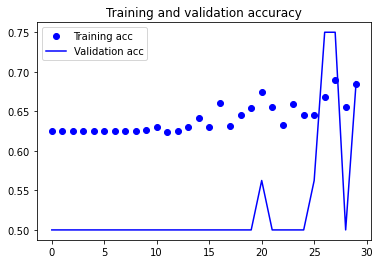

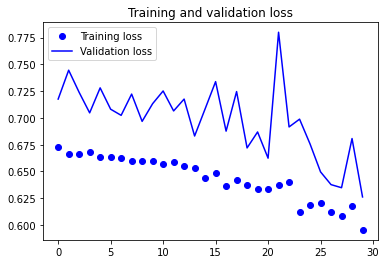

In [102]:
acc = history_aug.history['acc']
val_acc = history_aug.history['val_acc']
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [103]:
test_x, test_y = next(test_generator)

In [104]:
results_test_final = model.evaluate(test_x, test_y)

20/20 [==============================] - 0s 16ms/step - loss: 0.5303 - acc: 0.8814


In [105]:
results_test_final

[0.5302589535713196, 0.8814102411270142]

# Conclusion

## Limitations

## Recommendations

## Next Steps